In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import pycomlink as pycml

# Read instantaneous and min_max data
The min-max data was derived from the instantaneous example data set

In [3]:
cml_list = pycml.io.examples.get_75_cmls()
cml_list_min_max = pycml.io.examples.get_75_cmls_min_max()

75 CMLs read in
75 CMLs read in


# Plot both data types for some CMLs

<IPython.core.display.Javascript object>


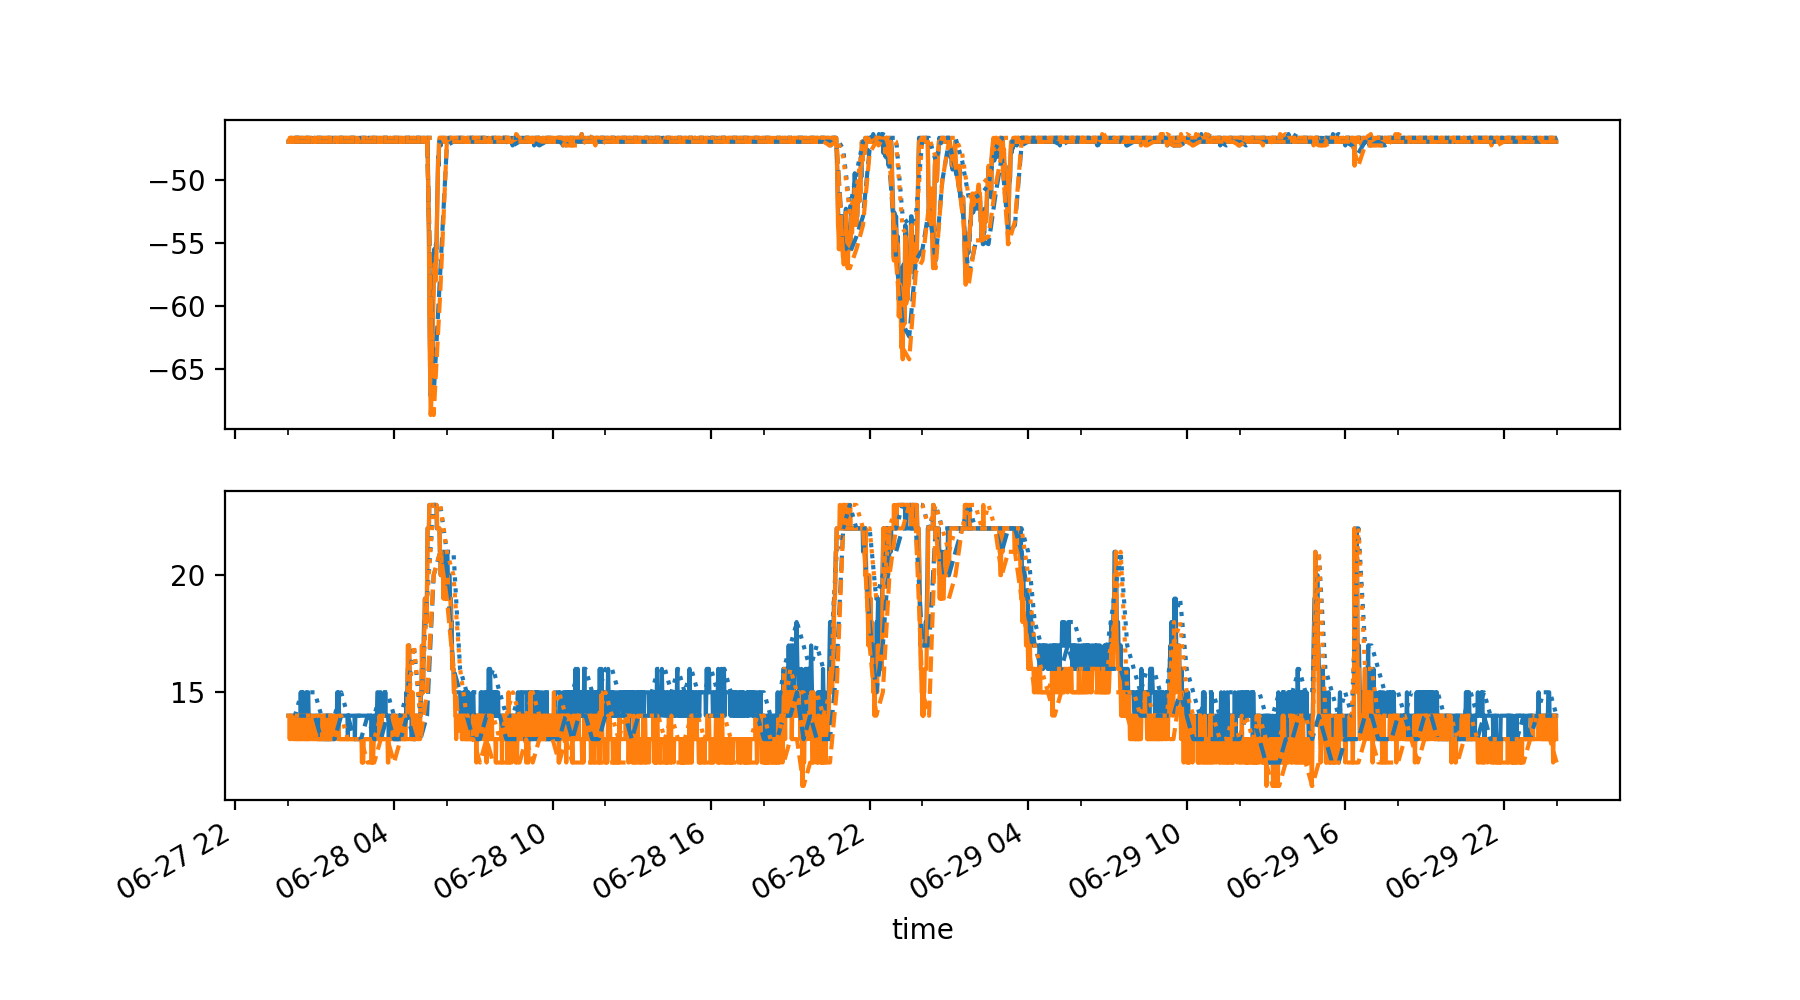

<IPython.core.display.Javascript object>


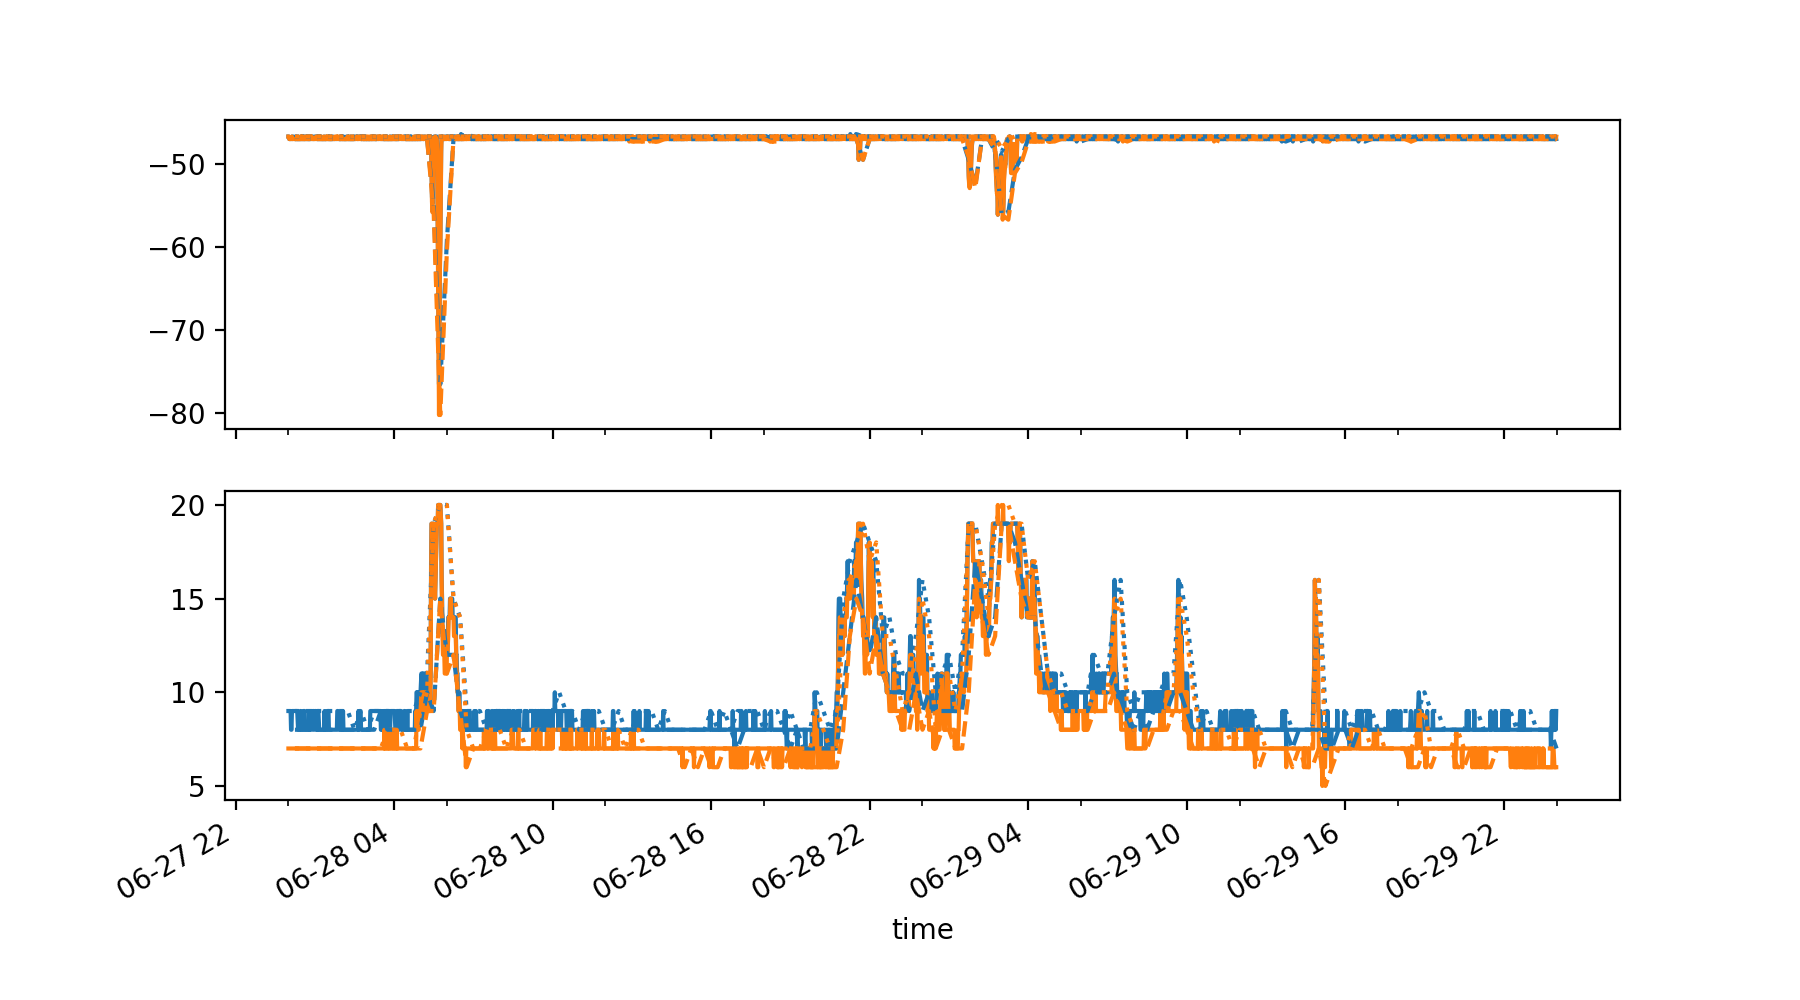

<IPython.core.display.Javascript object>


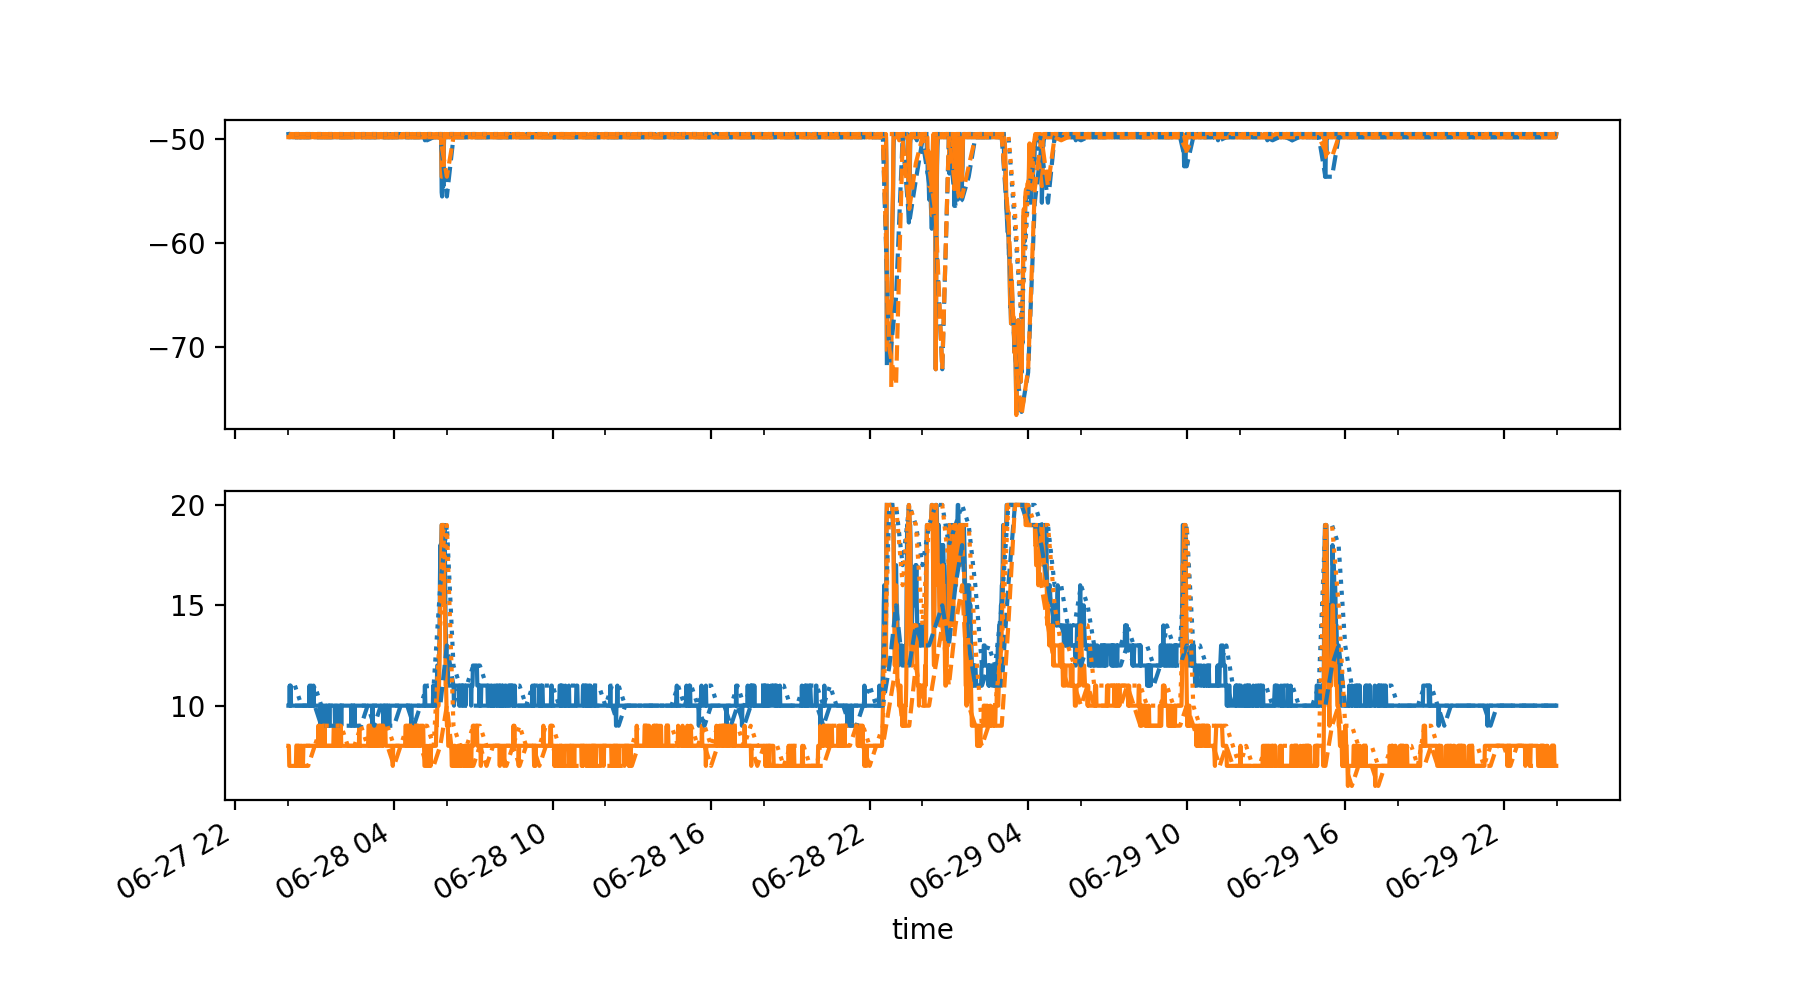

<IPython.core.display.Javascript object>


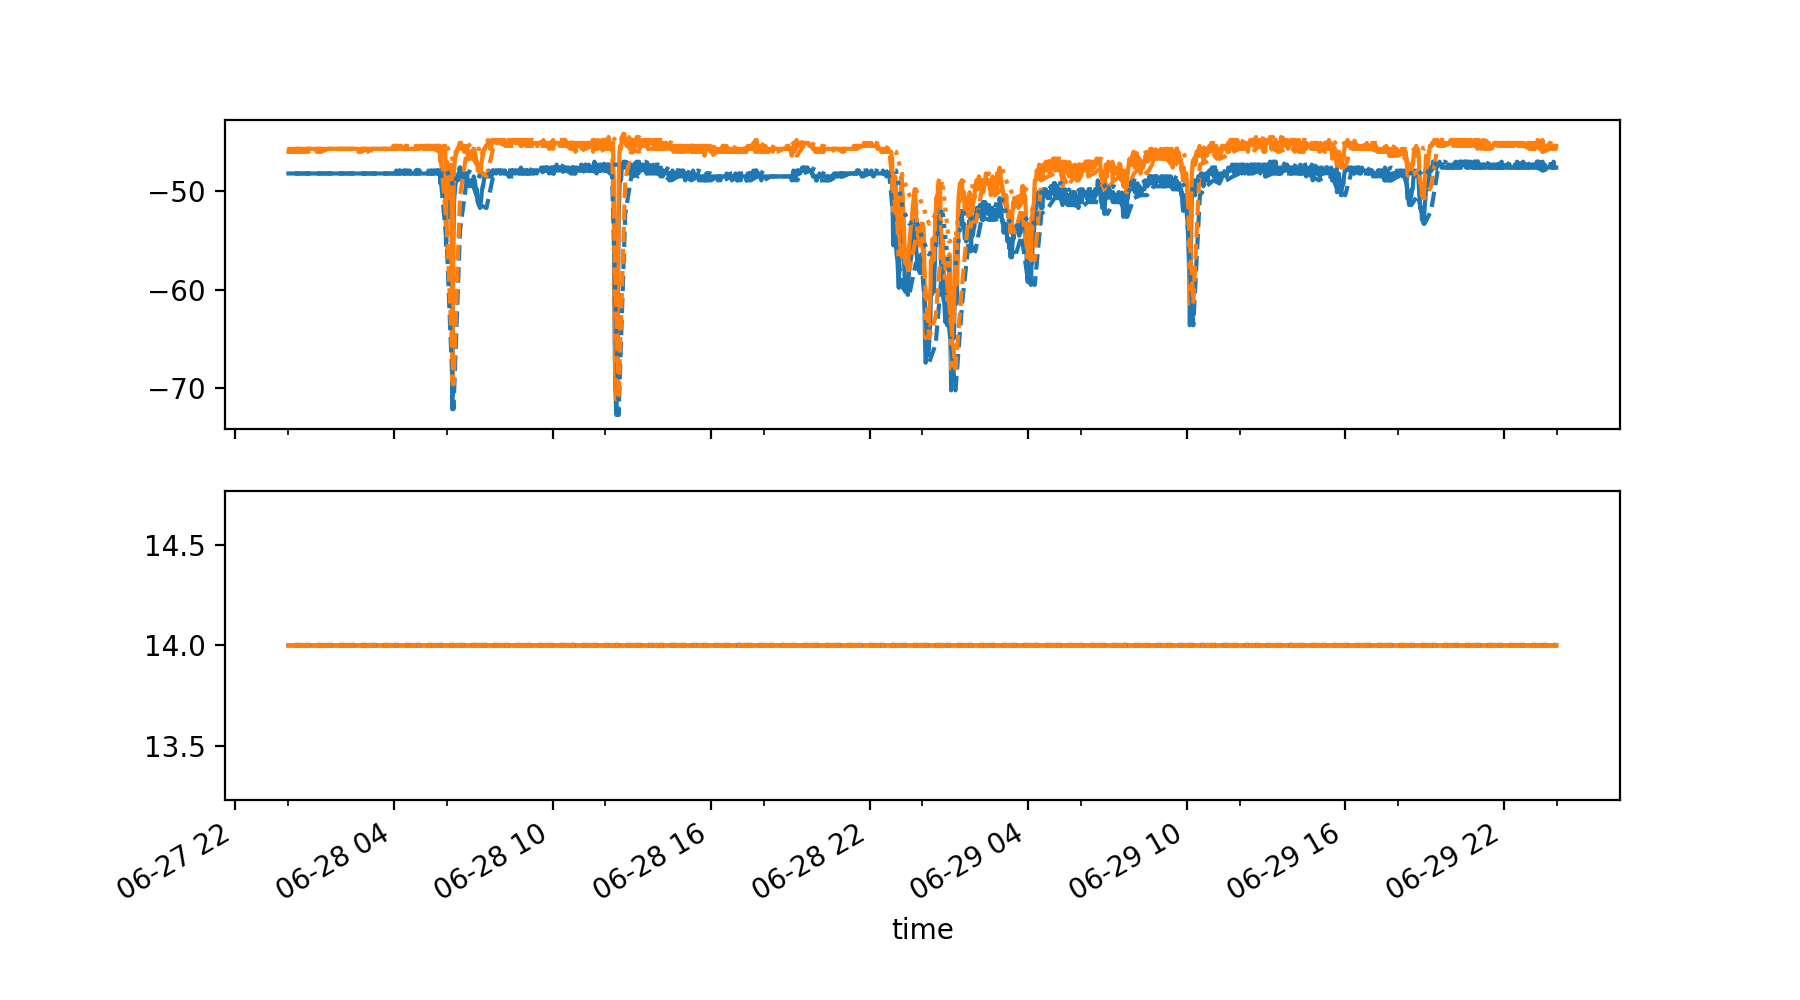

<IPython.core.display.Javascript object>


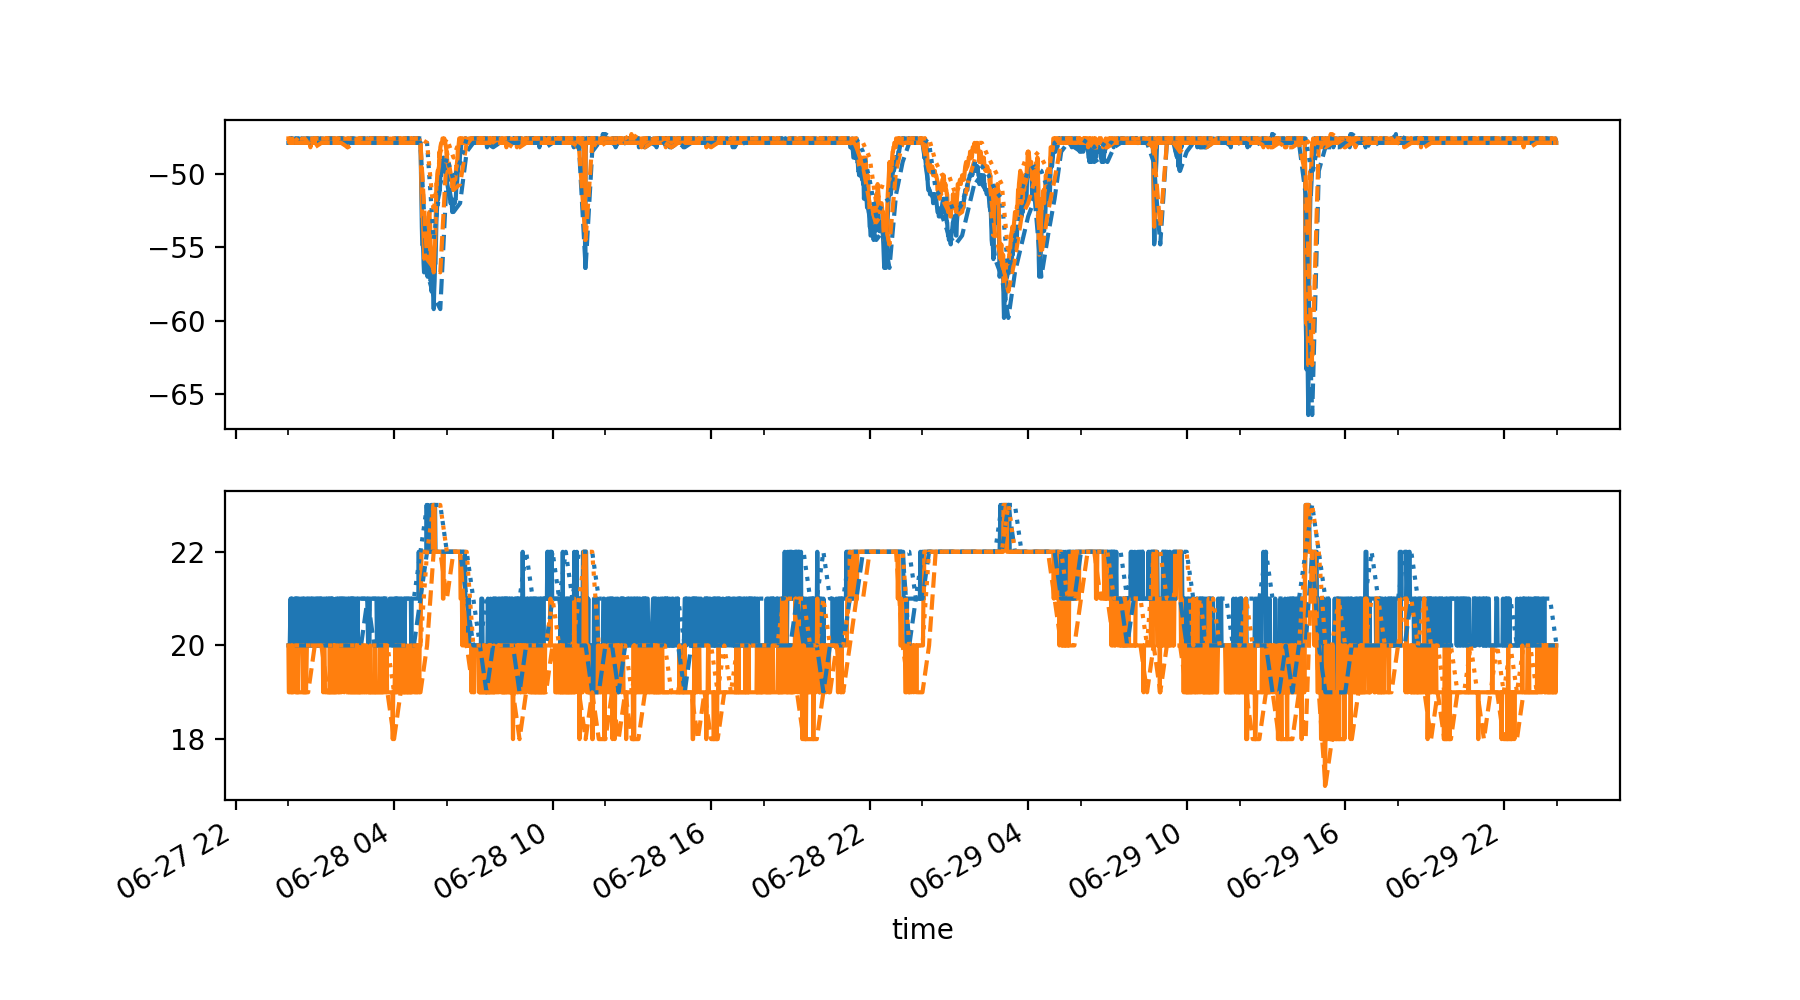

In [4]:
for cml, cml_min_max in zip(cml_list[:5], cml_list_min_max[:5]):
    fig, ax = plt.subplots(2, 1, figsize=(9, 5), sharex=True)
    cml.channel_1.data.rx.plot(ax=ax[0])
    cml.channel_2.data.rx.plot(ax=ax[0])
    cml.channel_1.data.tx.plot(ax=ax[1])
    cml.channel_2.data.tx.plot(ax=ax[1])
    
    cml_min_max.channel_1.data.rx_min.plot(ax=ax[0], color='C0', linestyle='--')
    cml_min_max.channel_2.data.rx_min.plot(ax=ax[0], color='C1', linestyle='--')
    cml_min_max.channel_1.data.rx_max.plot(ax=ax[0], color='C0', linestyle=':')
    cml_min_max.channel_2.data.rx_max.plot(ax=ax[0], color='C1', linestyle=':')

    cml_min_max.channel_1.data.tx_min.plot(ax=ax[1], color='C0', linestyle='--')
    cml_min_max.channel_2.data.tx_min.plot(ax=ax[1], color='C1', linestyle='--')
    cml_min_max.channel_1.data.tx_max.plot(ax=ax[1], color='C0', linestyle=':')
    cml_min_max.channel_2.data.tx_max.plot(ax=ax[1], color='C1', linestyle=':')

# TODO: Do processing of both data types 

# TODO: Plot rain rates for both data types